# Asteroid Detection Module

**Lecturer:** Quanzhi Ye<br>
**Jupyter Notebook Authors:** Quanzhi Ye, Ashish Mahabal, Dmitry Duev, & Cameron Hummels

This is a Jupyter notebook lesson taken from the GROWTH Summer School 2019.  For other lessons and their accompanying lectures, please see: http://growth.caltech.edu/growth-astro-school-2019-resources.html

## Objective
Compute the detection rate of fast-moving asteroids, asteroids that pass within ~20 lunar distances from Earth, and leave trails/streaks on astronomical images.

## Key steps
- Figure out which known asteroids will show up as streaks in ZTF images, and
- Examine the streak catalog to see how many of them are detected.
- [Optional] Run DeepStreaks, is a convolutional-neural-network, deep-learning system designed to efficiently identify streaking fast-moving near-Earth objects detected in the ZTF data

## Required dependencies

See GROWTH school webpage for detailed instructions on how to install these modules and packages.  Nominally, you should be able to install the python modules with `pip install <module>`.  The external astromatic packages are easiest installed using package managers (e.g., `rpm`, `apt-get`).

### Python modules
* python 3
* astropy
* numpy
* pandas
* astroquery
* matplotlib
* pillow

### External packages
None

In [1]:
import requests
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import os
import tarfile
from astroquery.jplhorizons import Horizons
import datetime
from astropy.time import Time
from IPython.display import Image as Image_jupyter
from IPython.display import display
import pdb
import warnings

If you are missing dependencies, pip-install them from this notebook:

In [2]:
# !pip install astroquery
# !pip install pillow

## Step 1: fast-moving asteroids that fall on ZTF images

We will loop over the catalog of known NEAs (Near-Earth Asteroids) and make a series of queries to JPL's Horizon service and IPAC's IRSA service, to determine if and when they will be visible at Palomar (where ZTF runs from).

Let's download the catalog of known NEAs from the Minor Planet Center (MPC).

In [3]:
# !wget -O data/NEA.txt https://www.minorplanetcenter.net/iau/MPCORB/NEA.txt
!ls -lhtr data

total 29M
-rwxr--r--    1 growth growth 347K Jul  2 19:14 check_fmo.txt
-rwxr--r--    1 growth growth 3.9M Jul  2 19:14 NEA.txt
-rw-r--r--    1 growth growth 4.3K Jul  8 11:28 rb_vgg6.architecture.json
-rw-r--r--    1 growth growth 4.3K Jul  8 11:28 sl_vgg6.architecture.json
-rw-r--r--    1 growth growth 8.1M Jul  8 11:28 rb_vgg6.weights.h5
-rw-r--r--    1 growth growth 8.1M Jul  8 11:28 sl_vgg6.weights.h5
-rw-r--r--    1 growth growth 4.3K Jul  8 11:28 kd_vgg6.architecture.json
-rw-r--r--    1 growth growth 8.1M Jul  8 11:28 kd_vgg6.weights.h5
drwxr-xr-x 1005 growth growth 136K Jul  9 01:50 run_merged


In [4]:
path_data = 'data'  # All relevant data are in data directory
path_nea = os.path.join(path_data, 'NEA.txt')

print('retrieving MPCORB...')
with open(path_nea, 'r') as f:
    mpcorb = f.read()
mpcorb = mpcorb.split("\n")
print('MPCORB file retrieved.')

retrieving MPCORB...
MPCORB file retrieved.


Let's convert the catalog into a `pandas` DataFrame for convenience. The format of the MPC catalog is described [here](https://www.minorplanetcenter.net/iau/info/MPOrbitFormat.html), it's best for machines but is also somewhat human readable.

In [5]:
df = pd.read_fwf(path_nea, 
                 colspecs=[(0, 7), (8, 13), (14, 19), (20, 25),
                           (26, 35), (37, 46), (48, 57), (59, 68), 
                           (70, 79), (80, 91), (92, 103), (105, 106), 
                           (107, 116), (117, 122), (123, 126), (127, 131), 
                           (131, 132), (132, 136), (137, 141), (142, 145), 
                           (146, 149), (150, 160), (161, 165), (166, 194), (194, 202)], 
                 names=['num', 'H', 'G', 'epoch', 
                        'n', 'omega', 'Omega', 'i', 
                        'e', 'n_daily', 'a', 'U',
                        'reference', 'num_obs', 'num_opp', 'date_1',
                        'date_2', 'date_3', 'rms_residual', 'coarse_ind_per', 
                        'presice_ind_per', 'computer_name', 'hex_flags', 'designation', 'date_last_obs'])
# display first and last five entries
display(df.head())
display(df.tail())

,num,H,G,epoch,n,omega,Omega,i,e,n_daily,...,date_1,date_2,date_3,rms_residual,coarse_ind_per,presice_ind_per,computer_name,hex_flags,designation,date_last_obs
0,00433,11.16,0.46,K1972,84.17190,178.83549,304.30424,10.82858,0.222739,0.559740,...,1893,-,2019,0.69,M-v,38h,MPCLINUX,1804,(433) Eros,20190509
1,00719,15.50,0.15,K1972,63.48955,156.16594,183.88436,11.56493,0.546328,0.229926,...,1911,-,2019,0.41,M-v,38h,MPCLINUX,1804,(719) Albert,20190125
2,00887,13.40,-0.12,K1972,210.09971,350.42271,110.42767,9.38774,0.569419,0.252978,...,1918,-,2018,0.65,M-v,3Eh,MPCLINUX,1804,(887) Alinda,20180712
3,01036,9.45,0.30,K1972,289.12776,132.38404,215.55779,26.68543,0.533195,0.226617,...,1924,-,2019,0.43,M-v,38h,MPCLINUX,1804,(1036) Ganymed,20190511
4,01221,17.70,0.15,K1972,274.74024,26.67623,171.33453,11.87634,0.435289,0.370632,...,1932,-,2018,1.15,M-v,3Eh,MPCW,1804,(1221) Amor,20181015


,num,H,G,epoch,n,omega,Omega,i,e,n_daily,...,date_1,date_2,date_3,rms_residual,coarse_ind_per,presice_ind_per,computer_name,hex_flags,designation,date_last_obs
20055,r8979,19.5,0.15,K1972,15.35038,79.71863,111.82334,22.73754,0.428860,0.302067,...,2005,-,2019,0.37,M-v,38h,MPCLINUX,0804,(538979) 2016 KE,20190103
20056,r9063,19.1,0.15,K1972,137.97986,240.58600,178.41222,10.78043,0.716156,0.536098,...,2004,-,2019,0.38,M-v,3Eh,MPCLINUX,8803,(539063) 2016 MK1,20190404
20057,r9694,21.3,0.15,K1972,29.40139,353.21066,214.24905,22.73216,0.175726,0.935490,...,2016,-,2018,0.40,M-v,3Eh,MPCLINUX,0803,(539694) 2016 TE93,20181028
20058,r9856,20.9,0.15,K1972,202.27763,32.20509,3.17296,16.48798,0.557657,0.970590,...,2017,-,2019,0.40,M-v,3Eh,MPCLINUX,0803,(539856) 2017 EV2,20190408
20059,r9940,17.8,0.15,K1972,266.31834,168.86624,41.34972,33.94655,0.458861,0.315406,...,2012,-,2018,0.40,M-v,38h,MPCLINUX,1804,(539940) 2017 HW1,20181111


Now let us loop over the MPC catalog to check the visibility for every NEA. We will do it for NEA 2018 CL (the first NEA found by ZTF), and it's up to you to write a loop for it.

First, we create an instance for the Horizons query. We only need to tell Horizons the name of the object we want to query, and the time window we want to query, and let Horizons do the heavy-lifting. Oh, and the three-letter-code for ZTF is `I41`, as described [here](https://www.minorplanetcenter.net/iau/lists/ObsCodesF.html). If the query returns zero entries, it means that the object is not observable at Palomar at the suggested time (interval).

In [6]:
ZTF_code = 'I41'

First, let us define a time window we would like to query for. Our default is 20180205, the day ZTF science observations started:

In [7]:
start_date = '20180205'
end_date = '20180206'

Then let's do all the tasks described above. For now, we do our test with 2018 CL (the first NEA found by ZTF).

In [8]:
# display db entry for 2018 CL:
display(df[df.designation == '2018 CL'])

obj_name = '2018 CL'

,num,H,G,epoch,n,omega,Omega,i,e,n_daily,...,date_1,date_2,date_3,rms_residual,coarse_ind_per,presice_ind_per,computer_name,hex_flags,designation,date_last_obs
15377,K18C00L,25.5,0.15,K1972,156.44302,141.71198,136.29656,11.85694,0.241386,1.247889,...,2,NaN,days,0.87,M-v,3Eh,MPCW,2802,2018 CL,20180207


In [9]:
obj = Horizons(id=obj_name, location=ZTF_code, \
               epochs={'start': '{}-{}-{}'.format(start_date[0:4], start_date[4:6], start_date[6:8]), \
               'stop': '{}-{}-{}'.format(end_date[0:4], end_date[4:6], end_date[6:8]), \
               'step': '1h'})

eph = obj.ephemerides(skip_daylight=True, airmass_lessthan=5.0)
if len(eph) <= 0:
    print('object {} was not observable at Palomar'.format(obj_name))

We also want to calculate the motion of the asteroid to see if it will show up as a streak in our images.

In [10]:
rate = np.sqrt(eph['RA_rate']**2+eph['DEC_rate']**2)

Now, since we just discovered the power of JPL Horizons... why don't we take a short detour and do something fun? Let's say, we want to see the predicted trajectory of 2018 CL...

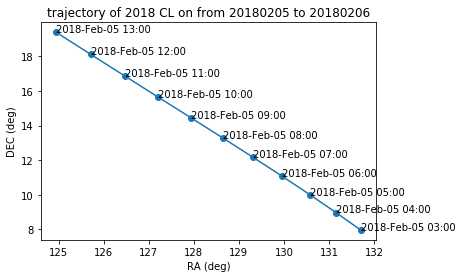

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(eph['RA'], eph['DEC'], 'o-')
ax.set_title('trajectory of 2018 CL on from %s to %s' % (start_date, end_date))
ax.set_xlabel('RA (deg)')
ax.set_ylabel('DEC (deg)')

for i, xy in enumerate(zip(eph['RA'], eph['DEC'])):
    ax.annotate('%s' % eph['datetime_str'][i], xy=xy, textcoords='data')

plt.show()

What about the change of azimuth and elevation angle?

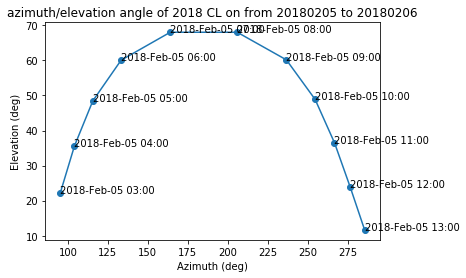

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(eph['AZ'], eph['EL'], 'o-')
ax.set_title('azimuth/elevation angle of 2018 CL on from %s to %s' % (start_date, end_date))
ax.set_xlabel('Azimuth (deg)')
ax.set_ylabel('Elevation (deg)')

for i, xy in enumerate(zip(eph['AZ'], eph['EL'])):
    ax.annotate('%s' % eph['datetime_str'][i], xy=xy, textcoords='data')

plt.show()

The complete lists of the values supported by `astroquery.jplhorizons` can be found [here](https://astroquery.readthedocs.io/en/latest/api/astroquery.jplhorizons.HorizonsClass.html#astroquery.jplhorizons.HorizonsClass.ephemerides). Play with it and be creative! For example, can you plot the change of RA/DEC rate over time? And what about the change of predicted V magnitude?

Now let's come back to our main journey. How fast does the asteroid need to be in order to show up as a streak? Let's take anything longer than 5 full-width-half-maximum (FWHM) as a streak. We know the exposure time of ZTF is 30 seconds, and the typical FWHM is 2''. Therefore, the minimum rate of motion is not too difficult to calculate:

In [13]:
min_rate = 2*5/30

print('minimum rate of motion for a streak: {:.2f} arcsec/sec.'.format(min_rate))

minimum rate of motion for a streak: 0.33 arcsec/sec.


If the object will be a fast-mover at some point within the time window being queried, we will use IPAC's Moving Object Search Tool (MOST) to get a list of the images that the object is a fast-mover on them.

In [14]:
if max(rate) > min_rate:
    params = {'catalog': 'ztf', 'input_type': 'name_input', 'obj_name': '{}'.format(obj_name), \
              'obs_begin': '{}-{}-{}'.format(start_date[0:4], start_date[4:6], start_date[6:8]), \
              'obs_end': '{}-{}-{}'.format(end_date[0:4], end_date[4:6], end_date[6:8]), \
              'output_mode': 'Brief'}
    irsa_return = requests.get('https://irsa.ipac.caltech.edu/cgi-bin/MOST/nph-most', params=params)

...and MOST did give us something, right?

In [15]:
from io import StringIO
r = irsa_return.text.split("\n")
r = [' '.join(rr.split())[0:] for rr in r]
data_str = '\n'.join(r[20:])
# display(data_str)

column_names = [cn.strip() for cn in r[18].split('|')[1:-1]]
# display(column_names)

dff = pd.read_csv(StringIO(data_str), sep=' ', parse_dates=[[22, 23]], header=None)
column_names.remove('obsdate')
dff.columns = ['obsdate'] + column_names
dff

,obsdate,ra_obj,dec_obj,sun_dist,geo_dist,dist_ctr,phase,vmag,match,ra,...,imgtypecode,obsjd,ra1,dec1,ra2,dec2,ra3,dec3,ra4,dec4
0,2018-02-05 05:33:25,130.243140,10.591412,0.9936,0.0077,0.3695,9.6662,15.69,1,129.946763,...,o,2.458155e+06,130.387829,10.796161,129.508055,10.798785,129.506884,9.932329,130.383994,9.929949
1,2018-02-05 06:01:52,129.946506,11.101031,0.9935,0.0077,0.1305,9.6479,15.67,1,129.949892,...,o,2.458155e+06,130.392207,11.663277,129.509977,11.666109,129.508681,10.799672,130.388448,10.797038
2,2018-02-05 06:31:50,129.625980,11.645721,0.9934,0.0076,0.5217,9.6703,15.65,1,129.950695,...,o,2.458155e+06,130.392986,11.664048,129.510776,11.666846,129.509495,10.800441,130.389246,10.797863
3,2018-02-05 06:32:33,129.618211,11.658854,0.9934,0.0076,0.3954,9.6713,15.65,1,129.648394,...,o,2.458155e+06,130.091191,12.485963,129.206230,12.486623,129.207328,11.620350,130.089108,11.619538
4,2018-02-05 07:01:11,129.304417,12.186967,0.9934,0.0075,0.2490,9.7350,15.64,1,129.070328,...,o,2.458155e+06,129.513283,12.718625,128.627360,12.718549,128.629102,11.852312,129.511896,11.852223
5,2018-02-05 07:01:54,129.296470,12.200286,0.9934,0.0075,0.3748,9.7371,15.64,1,129.649259,...,o,2.458155e+06,130.092073,12.486768,129.207114,12.487391,129.208189,11.621136,130.089971,11.620310
6,2018-02-05 07:30:26,128.976880,12.733908,0.9933,0.0075,0.4280,9.8423,15.62,1,129.071104,...,o,2.458155e+06,129.515615,13.585218,128.626757,13.584987,128.628209,12.718695,129.514140,12.718796


Here is a loop over the query result from MOST to find out which images will contain the target as a fast-mover. Note that we want the predicted magnitude of the object to be <20 since that's the typical depth of ZTF.

In [16]:
limiting_magnitude = 20

We also make another query to Horizons to ensure the object is really a fast-mover on these dates. We do this as a double-check since Horizons produces the most precise ephemerides for NEAs. Horizons also tells us what the expected positional uncertainty will be. Obviously, we don't want the positional uncertainty to be too big -- say, over 20".

In [17]:
max_unc = 20

And then we print out all the metadata that are potentially useful. We will just return the first entry (or it will be a very long entry!)

In [18]:
w = dff.vmag < limiting_magnitude

for index, row in dff.loc[w].iterrows():
    obj_this = Horizons(id=obj_name, location=ZTF_code, epochs=row.obsjd)
    eph = obj_this.ephemerides()
    ztf_entry_rate = np.sqrt(eph['RA_rate'][0]**2 + eph['DEC_rate'][0]**2)

    if ztf_entry_rate > min_rate:
        ztf_entry_unc = np.sqrt(eph['RA_3sigma'][0]**2 + eph['DEC_3sigma'][0]**2)

        if ztf_entry_unc < max_unc:
            print('hit: object {}'.format(obj_name))

            print('object name:', obj_name)
            print('image date (UT):', row.obsdate)
            print('fracday:', row.filefracday)
            print('filter code:', row.filtercode)
            print('distance to the Sun:', row.sun_dist, 'AU')
            print('distance to the Earth:', row.geo_dist, 'AU')
            print('predicted V magnitude:', row.vmag)
            print('ecliptic latitude:', eph['ObsEclLat'][0])
            print('positional uncertainty: {:.2f} arcsec'.format(ztf_entry_unc))

            break

hit: object 2018 CL
object name: 2018 CL
image date (UT): 2018-02-05 05:33:25
fracday: 20180205231528
filter code: zr
distance to the Sun: 0.9936 AU
distance to the Earth: 0.0077 AU
predicted V magnitude: 15.69
ecliptic latitude: -7.4574757
positional uncertainty: 2.31 arcsec


Voila! You made it. Note that it takes quite a bit of time (a day or two) to loop over the entire NEA catalog -- this is because Horizons has to calculate the ephemerides for each of these ~15,000 NEAs and this is slow! Therefore, we provide a pre-generated result file for you to proceed to step 2. 

But do take a few known asteroids and see what you get for them. 

## Step 2: compare the catalog derived from step 1 to the source catalog generated by ZTF streak detection pipeline

Let's read in the result of step 1... (OK, we cheated, it is pre-generated)

In [19]:
path_fmo = os.path.join(path_data, 'check_fmo.txt')
check_fmo = np.genfromtxt(path_fmo, dtype=None, \
                          delimiter=(12, 10, 6, 10, 10, 10, 5, 10, 10, 10), \
                          encoding='utf-8',
                          names=["object", "dateUT", "filter", "rate", "sundist", \
                                "geodist", "vmag", "ecllat", "unc", "fracday"])[:-1]
# convert to pandas dataframe
df_check_fmo = pd.DataFrame(check_fmo)
# comb object names:
df_check_fmo['object'] = df_check_fmo['object'].str.strip()
# compute jd's:
df_check_fmo['jd'] = df_check_fmo['dateUT'].apply(lambda x: 
                                                  Time(datetime.datetime.strptime(str(x), '%Y%m%d')).jd)
df_check_fmo['jd'] = df_check_fmo['jd'] + df_check_fmo['fracday']/1000000

And also we read the source files from ZTF... essentially, these are a large number of "streak_qa" files, each file contains candidate streaks in one image. Apparently, we want to loop over them and see if there is any candidate that coincides the position of a known streaking NEA. We also record the rate and mag of detections and non-detections for diagnostic purposes.

For a demonstration, let us pick one of them to show how this whole thing works. Let us start with our old friend, `2018 CL`.

In [20]:
# for cfi in check_fmo:
#     if cfi[0].strip() == '2018 CL':
#         break
ww = df_check_fmo.object == '2018 CL'
# df_check_fmo.loc[ww, 'jd'].values
df_check_fmo.loc[ww]

,object,dateUT,filter,rate,sundist,geodist,vmag,ecllat,unc,fracday,jd
2154,2018 CL,20180205,zr,1.227526,0.9936,0.0077,15.69,-7.4575,2.3094,231528,2.458155e+06
2155,2018 CL,20180205,zr,1.248343,0.9935,0.0077,15.67,-7.0404,2.2283,251296,2.458155e+06
2156,2018 CL,20180205,zr,1.269654,0.9934,0.0076,15.65,-6.5944,2.1525,272106,2.458155e+06
2157,2018 CL,20180205,zr,1.270154,0.9934,0.0076,15.65,-6.5837,2.1503,272593,2.458155e+06
2158,2018 CL,20180205,zr,1.289839,0.9934,0.0075,15.64,-6.1510,2.0896,292488,2.458155e+06
2159,2018 CL,20180205,zr,1.290324,0.9934,0.0075,15.64,-6.1401,2.0887,292986,2.458155e+06
2160,2018 CL,20180205,zr,1.309231,0.9933,0.0075,15.63,-5.7026,2.0425,312789,2.458155e+06
2161,2018 CL,20180206,zr,2.040896,0.9908,0.0060,16.25,20.8280,1.6937,200660,2.458156e+06
2162,2018 CL,20180206,zr,2.036865,0.9907,0.0060,16.29,21.5240,1.7108,221644,2.458156e+06
2163,2018 CL,20180206,zr,2.036738,0.9907,0.0060,16.29,21.5400,1.7116,222141,2.458156e+06


What are the uncertainty ranges (in arcsec) for these entries?

In [21]:
df_check_fmo.loc[ww, 'unc'].values

array([2.3094, 2.2283, 2.1525, 2.1503, 2.0896, 2.0887, 2.0425, 1.6937,
       1.7108, 1.7116, 1.7434])

This is very precise! Well, we know it should be small because the orbit from JPL was calculated using ZTF observations :)

Now, let us obtain the predicted coordinates for `2018 CL` at these epochs using what we have just learned in Step 1.

In [22]:
expTimeJD = df_check_fmo.loc[ww, 'jd'].values
expTimeJD

array([2458154.731528, 2458154.751296, 2458154.772106, 2458154.772593,
       2458154.792488, 2458154.792986, 2458154.812789, 2458155.70066 ,
       2458155.721644, 2458155.722141, 2458155.739988])

In [23]:
obj_this = Horizons(id=obj_name, location=ZTF_code, epochs=expTimeJD)
eph = obj_this.ephemerides()

eph

targetname,datetime_str,datetime_jd,H,G,solar_presence,flags,RA,DEC,RA_app,DEC_app,RA_rate,DEC_rate,AZ,EL,AZ_rate,EL_rate,sat_X,sat_Y,sat_PANG,siderealtime,airmass,magextinct,V,illumination,illum_defect,sat_sep,sat_vis,ang_width,PDObsLon,PDObsLat,PDSunLon,PDSunLat,SubSol_ang,SubSol_dist,NPole_ang,NPole_dist,EclLon,EclLat,r,r_rate,delta,delta_rate,lighttime,vel_sun,vel_obs,elong,elongFlag,alpha,lunar_elong,lunar_illum,sat_alpha,sunTargetPA,velocityPA,OrbPlaneAng,constellation,TDB-UT,ObsEclLon,ObsEclLat,NPole_RA,NPole_DEC,GlxLon,GlxLat,solartime,earth_lighttime,RA_3sigma,DEC_3sigma,SMAA_3sigma,SMIA_3sigma,Theta_3sigma,Area_3sigma,RSS_3sigma,r_3sigma,r_rate_3sigma,SBand_3sigma,XBand_3sigma,DoppDelay_3sigma,true_anom,hour_angle,alpha_true,PABLon,PABLat
---,---,d,mag,---,---,---,deg,deg,deg,deg,arcsec / h,arcsec / h,deg,deg,arcsec / min,arcsec / min,arcsec,arcsec,deg,---,---,mag,mag,%,arcsec,arcsec,---,arcsec,deg,deg,deg,deg,deg,arcsec,deg,arcsec,deg,deg,AU,km / s,AU,km / s,min,km / s,km / s,deg,---,deg,deg,%,deg,deg,deg,deg,---,s,deg,deg,deg,deg,deg,deg,---,min,arcsec,arcsec,arcsec,arcsec,deg,arcsec2,arcsec,km,km / s,Hz,Hz,s,deg,---,deg,deg,deg
str9,str24,float64,float64,float64,str1,str1,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,str1,int64,int64,int64,int64,int64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str2,float64,float64,float64,float64,float64,float64,float64,str3,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
(2018 CL),2018-Feb-05 05:33:24.019,2458154.731527998,25.5,0.15,,,130.24304,10.59115,130.49171,10.52376,-2179.93,3843.943,124.2903,55.1746,612.91,693.91,594314.5,95242.96,122.733,6.7875558247,1.217,0.21,15.55,99.291,--,612957.6,*,--,--,--,--,--,235.37,0.0,--,--,136.0615,-0.0588,0.993552869965,-4.8924091,0.00768971056396,-5.5523857,0.063953,27.28735,8.81488,170.266,/T,9.6587,69.6,73.2,0.0714,55.334,274.969,6.00716,Cnc,69.18491,130.0804119,-7.4577146,--,--,215.728881,29.094296,21.5336100124,0.000354,1.32,1.895,2.098,0.965,-61.08,12.72,2.309,1487.7261,0.0070343,111.58,405.53,0.009925,217.3296,-1.911891179,9.6624,132.954,-3.7651
(2018 CL),2018-Feb-05 06:01:51.974,2458154.751296,25.5,0.15,,,129.94623,11.10104,130.19566,11.03406,-2233.08,3899.962,133.9728,60.3813,689.84,616.66,593238.0,97058.28,119.167,7.2632867938,1.15,0.198,15.53,99.293,--,613028.4,*,--,--,--,--,--,238.82,0.0,--,--,136.0788,-0.0551,0.9934969982,-4.894901,0.00762695954652,-5.439166,0.063431,27.28936,8.79055,170.2857,/T,9.6398,70.2,73.0,0.0704,58.787,274.758,5.5131,Cnc,69.18491,129.6637802,-7.0403874,--,--,215.059059,29.046948,22.0080011039,0.000354,1.251,1.844,2.034,0.909,-61.82,11.62,2.228,1475.7983,0.0069451,110.22,400.57,0.009845,217.3509,-1.41642367,9.6438,132.7537,-3.5551
(2018 CL),2018-Feb-05 06:31:49.958,2458154.772106,25.5,0.15,,m,129.62568,11.64573,129.87595,11.57917,-2285.77,3958.154,147.4687,64.9993,789.3,481.45,592076.6,98997.85,115.351,7.764094176,1.103,0.19,15.51,99.29,--,612951.3,*,--,--,--,--,--,242.52,0.0,--,--,136.097,-0.0512,0.993438150594,-4.8975326,0.00756232325144,-5.3157637,0.062894,27.29148,8.76104,170.2642,/T,9.6618,70.9,72.8,0.0696,62.479,274.524,4.98493,Cnc,69.184911,129.2172479,-6.5944512,--,--,214.342815,28.990766,22.5073968139,0.000354,1.194,1.791,1.972,0.862,-62.232,10.68,2.152,1463.4023,0.0068488,108.74,395.22,0.009763,217.3734,-0.894302169,9.6661,132.5388,-3.3306
(2018 CL),2018-Feb-05 06:32:32.035,2458154.772593,25.5,0.15,,m,129.61809,11.65857,129.86837,11.59203,-2286.96,3959.505,147.8337,65.0927,791.73,477.41,592049.1,99043.58,115.261,7.7758141697,1.102,0.19,15.51,99.29,--,612947.6,*,--,--,--,--,--,242.6,0.0,--,--,136.0974,-0.0512,0.993436773052,-4.8975943,0.00756082847737,-5.3128316,0.062881

A simplistic approach is to loop through each small folder generated by findStreaks and see if there is any candidate matching the predicted RA and DEC:

In [24]:
detectionRadius = 5/3600

In [25]:
path_streaks = os.path.join(path_data, 'run_merged', 'ztf*')
d = sorted(glob.glob(path_streaks))
# display(d)

# let's look at the first epoch:
targetRA = eph['RA'][0]
targetDec = eph['DEC'][0]

for di in d:
    fileName = os.path.basename(di)
    streaksQA_path = '{}/{}_streaksqa.txt'.format(di, fileName)
    
    if os.stat(streaksQA_path).st_size > 500:
        try:
            streaksQA = np.loadtxt(streaksQA_path, delimiter=',', comments='\\')
            for streaksQA_item in streaksQA:
                if (abs(streaksQA_item[1]-targetRA) < detectionRadius and \
                abs(streaksQA_item[2]-targetDec) < detectionRadius) or \
                (abs(streaksQA_item[3]-targetRA) < detectionRadius and \
                abs(streaksQA_item[4]-targetDec) < detectionRadius):
                        print('YES! Streak found in', streaksQA_path)
        except:
            continue

YES! Streak found in data/run_merged/ztf_20180205231528_000517_zr_c06_o_q4/ztf_20180205231528_000517_zr_c06_o_q4_streaksqa.txt


Wonderful! We have a hit! We can even take a look at the cutout to see what it looks like:

ztf_20180205231528_000517_zr_c06_o_q4
data/run_merged/ztf_20180205231528_000517_zr_c06_o_q4/ztf_20180205231528_000517_zr_c06_o_q4_cutouts/strkid4002315323150002_pid400231532315_scimref.jpg


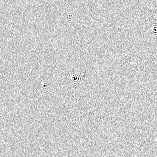

In [26]:
for di in d:
    fileName = os.path.basename(di)
            
    streaksQA_path = '{}/{}_streaksqa.txt'.format(di, fileName)
    
    if os.stat(streaksQA_path).st_size > 500:
        try:
            streaksQA = np.loadtxt(streaksQA_path, delimiter=',', comments='\\')
            for streaksQA_item in streaksQA:
                if (abs(streaksQA_item[1]-targetRA) < detectionRadius and \
                    abs(streaksQA_item[2]-targetDec) < detectionRadius) or \
                    (abs(streaksQA_item[3]-targetRA) < detectionRadius and \
                    abs(streaksQA_item[4]-targetDec) < detectionRadius):
                        folder_name = di.split('/')[-1]
                        print(folder_name)
                        path_jpgs = os.path.join(path_data, 'run_merged', 
                                                 folder_name, folder_name + '_cutouts', '*jpg')
                        jpgs = glob.glob(path_jpgs)
                        print(jpgs[0])
                        display(Image_jupyter(filename = jpgs[0], width=157, height=157))
        except:
            continue

Voila! Now, homework for you: can you use the example shown above to work out the detection efficiency of ZTF?

## Step 3: run a light version of DeepStreaks [optional]

`DeepStreaks` is a convolutional-neural-network, deep-learning system designed to efficiently identify streaking fast-moving near-Earth objects, detected in the ZTF data. 

For details, please see [Duev et al., MNRAS.486.4158D, 2019](https://academic.oup.com/mnras/article-abstract/486/3/4158/5472913), [arXiv:1904.05920](https://arxiv.org/pdf/1904.05920.pdf), and [this Github repo](https://github.com/dmitryduev/DeepStreaks).

We will load a light version of DeepStreaks and run it on the streaks to see if they would have been identified. `DeepStreaks` is implemented using `Google`'s `TensorFlow` library, so we will need it for this part.

In [27]:
#!pip install tensorflow
import tensorflow as tf
from PIL import Image, ImageOps

In [28]:
def load_model_helper(path, model_base_name):
    # return load_model(path)
    with open(os.path.join(path, f'{model_base_name}.architecture.json'), 'r') as json_file:
        loaded_model_json = json_file.read()
    m = tf.keras.models.model_from_json(loaded_model_json)
    m.load_weights(os.path.join(path, f'{model_base_name}.weights.h5'))

    return m

`DeepStreaks` consists of three sets of binary classifiers: the first one (real/bogus or $rb$) decides if a particular cutout contains a steak-like object (which includes the actual streaks and cosmic rays, for example), the second (short/long or $sl$) decides if a streak is long (i.e. caused by something that moves too fast like a LEO satellite) or short, and the third (keep/ditch or $kd$) makes the final judgement. If all three parts output a score >0.5, a streak is designated as a plausible FMO candidate.

Download models from Github if necessary:

In [29]:
model_names = {
    "rb_vgg6": "5b96af9c0354c9000b0aea36_VGG6_20181207_151757",
    "sl_vgg6": "5b99b2c6aec3c500103a14de_VGG6_20181207_182618",
    "kd_vgg6": "5be0ae7958830a0018821794_VGG6_20190210_011644"
}

base_url = 'https://raw.githubusercontent.com/dmitryduev/DeepStreaks/master/service/models/'

for model in model_names.keys():
    print('fetching {}'.format(model))
    for part in ('.architecture.json', '.weights.h5'):
        r = requests.get(os.path.join(base_url, model_names[model] + part))
        with open(os.path.join(path_data, model + part), 'wb') as f:
            f.write(r.content)


fetching rb_vgg6
fetching sl_vgg6
fetching kd_vgg6


Load models:

In [30]:
models = {m: load_model_helper(path_data, m) for m in model_names.keys()}

Now let us load the cutout image and resize it to the shape expected by the models.

In [31]:
def load_cutout(path_image, resize=(144, 144)):
    img = np.array(ImageOps.grayscale(Image.open(path_image)).resize(resize, Image.BILINEAR)) / 255.
    img = np.expand_dims(img, 2)
    return img

In [32]:
img = load_cutout(jpgs[0])
img = np.expand_dims(img, 0)
img.shape

(1, 144, 144, 1)

In [33]:
for mn, m in models.items():
    score = m.predict(img)
    print('{} score: {:.2f}'.format(mn, score[0][0]))

rb_vgg6 score: 0.68
sl_vgg6 score: 1.00
kd_vgg6 score: 0.00


Great! This streak would have been successfully identified by `DeepStreaks`!

#### Run `DeepStreaks` on some random streaks

In [34]:
path_jpgs = os.path.join(path_data, 'run_merged', '*', '*', '*jpg')
cutouts = glob.glob(path_jpgs)

# set a random seed for result repeatability
np.random.seed(5)
sample = np.random.choice(cutouts, size=10)
# sample

df_sample = pd.DataFrame.from_records([{'name': os.path.basename(ii)} for ii in sample])

0: strkid4782480705150001_pid478248070515_scimref.jpg


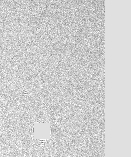

1: strkid4291671162150012_pid429167116215_scimref.jpg


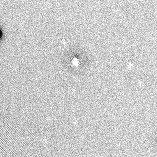

2: strkid3994190631150017_pid399419063115_scimref.jpg


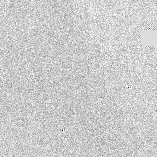

3: strkid4725070029150084_pid472507002915_scimref.jpg


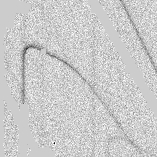

4: strkid4043829360150013_pid404382936015_scimref.jpg


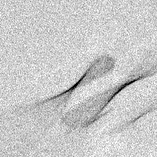

5: strkid3994200531150008_pid399420053115_scimref.jpg


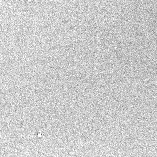

6: strkid4043982860150011_pid404398286015_scimref.jpg


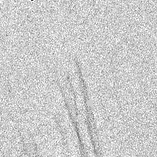

7: strkid3994245031150032_pid399424503115_scimref.jpg


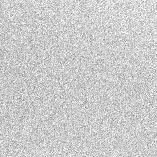

8: strkid4292585812150005_pid429258581215_scimref.jpg


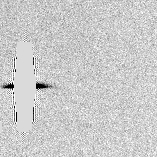

9: strkid3994254831150012_pid399425483115_scimref.jpg


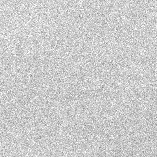

In [35]:
for ni, ii in enumerate(sample):
    print('{}: {}'.format(ni, os.path.basename(ii)))
    display(Image_jupyter(filename=ii, width=157, height=157))

In [36]:
imgs = np.array([load_cutout(x) for x in sample])
imgs.shape

(10, 144, 144, 1)

Let us now compute scores in batches and see if `DeepStreaks` would declare any of these streaks plausible candidates.

In [37]:
for mn, m in models.items():
    scores = m.predict(imgs)
    df_sample[mn] = scores

display(df_sample)

print('Plausible candidates:')

w = (df_sample['rb_vgg6'] > 0.5) & (df_sample['sl_vgg6'] > 0.5) & (df_sample['kd_vgg6'] > 0.5)
display(df_sample.loc[w])

,name,rb_vgg6,sl_vgg6,kd_vgg6
0,strkid4782480705150001_pid478248070515_scimref...,3.368258e-04,0.999874,8.484721e-05
1,strkid4291671162150012_pid429167116215_scimref...,1.490116e-07,0.041698,0.000000e+00
2,strkid3994190631150017_pid399419063115_scimref...,5.904734e-04,0.999190,1.596470e-01
3,strkid4725070029150084_pid472507002915_scimref...,1.000000e+00,0.001227,0.000000e+00
4,strkid4043829360150013_pid404382936015_scimref...,0.000000e+00,0.511049,0.000000e+00
5,strkid3994200531150008_pid399420053115_scimref...,5.155802e-06,0.996235,3.379565e-02
6,strkid4043982860150011_pid404398286015_scimref...,1.279805e-01,0.000000,1.788139e-07
7,strkid3994245031150032_pid399424503115_scimref...,3.873050e-03,0.987488,6.705958e-01
8,strkid4292585812150005_pid429258581215_scimref...,0.000000e+00,0.478033,1.344086e-05
9,strkid3994254831150012_pid399425483115_scimref...,8.137374e-02,0.996968,3.687158e-01


Plausible candidates:


,name,rb_vgg6,sl_vgg6,kd_vgg6


Hooray! Streaks #4 and #8 were correctly identified!